## Initial Analysis of Gulf Stream Cruise Data

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime

#### Pull in CDOM data and ship TSG/GPS data

In [11]:
path = 'data/wscd859/' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_tmp = pd.read_csv(filename, index_col=None, header=1)
    li.append(df_tmp)
cdom_df = pd.concat(li, axis=0, ignore_index=True)

cdom_df['utc_dt'] = pd.to_datetime(cdom_df['yyyy/mm/dd HH:MM:SS.fff'])

cdom_df = cdom_df.set_index('utc_dt')

df = pd.read_csv("data/Data every 1 min_001.elg")
df.head()

Date      Time  SW-ZDA-Year  SW-ZDA-Month  SW-ZDA-Day  SW-ZDA-Time  \
0  09/04/2021  22:57:59         2021             9           4    230119.69   
1  09/04/2021  22:58:59         2021             9           4    230220.00   
2  09/04/2021  22:59:59         2021             9           4    230319.70   
3  09/04/2021  23:00:59         2021             9           4    230420.70   
4  09/04/2021  23:01:59         2021             9           4    230520.70   

   SW-GGA-Lat SW-GGA-NorS  SW-GGA-Long SW-GGA-EorW  ...  \
0   3438.0721           N    7639.5131           W  ...   
1   3437.7653           N    7639.3397           W  ...   
2   3437.4662           N    7639.1743           W  ...   
3   3437.1706           N    7639.0156           W  ...   
4   3436.8780           N    7638.8561           W  ...   

   SW-Weather-HumidRel-%  SW-Wind-WindSpeedRel  SW-Wind-WindAngleRel  \
0                   62.1                 23.70                346.29   
1                   62.6                 23.70                347.29   
2                   62.0                 19.98                344.39   
3                   63.8                 23.09                346.09   
4                   63.5                 23.38                348.79   

   TrueWind-DRV-SPEED  TrueWind-DRV-DIRECTION  TSG--temp-SBE38  TSG--sal  \
0                3.65                  137.98          26.5469   36.0464   
1                0.92                  120.30          26.5202   35.9130   
2                1.74                  100.41          26.7050   35.9890   
3                4.72                  123.35          26.7135   36.0296   
4                4.31                  152.50          26.8741   36.0758   

   SW-Depth-DBT-Depth below transducer (m)  DepthOverall-DRV-VALUE  \
0                                    15.57                   16.57   
1                                    16.51                   17.51   
2                                    16.34                   17.34   
3                                    16.23                   17.23   
4                                    16.52                   17.52   

   Unnamed: 24  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 25 columns]

In [12]:
cdom_df.head()

yyyy/mm/dd HH:MM:SS.fff      V
utc_dt                                                 
2021-09-06 19:48:36.127  2021/09/06 19:48:36.127  0.110
2021-09-06 19:48:37.127  2021/09/06 19:48:37.127  0.110
2021-09-06 19:48:38.127  2021/09/06 19:48:38.127  0.111
2021-09-06 19:48:39.126  2021/09/06 19:48:39.126  0.111
2021-09-06 19:48:40.127  2021/09/06 19:48:40.127  0.111

In [8]:
# This first one is the right way to do this

In [ ]:
date_time_strs = df['SW-ZDA-Year'].astype('str') + ' ' + df['SW-ZDA-Month'].astype('str') + ' ' + df['SW-ZDA-Day'].astype('str') + ' ' + df['SW-ZDA-Time'].astype('str').str[:-2].str.replace('.','')

df['datetime'] = [datetime.strptime(x, '%Y %m %d %H%M%S') for x in date_time_strs]
df['utc_dt'] = df['datetime']
df  = df.set_index('utc_dt')

In [13]:
date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]
df['utc_dt'] = df['datetime']+ timedelta(minutes=4)
df  = df.set_index('utc_dt')

In [15]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

<AxesSubplot:>

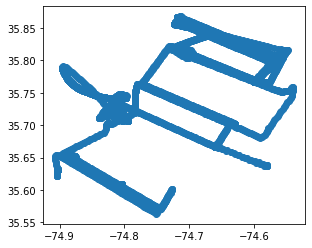

In [16]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.loc['2021-09-5 11:00:00':'2021-09-8 20:45:00'].plot()

#### Visualizing SST from GOES

In [17]:
goes_ds = xr.open_dataset('data/jplStarG16SSTv270_8997_d932_2101.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'sea_surface_temperature' has multiple fill values {-327.67, -327.68}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [18]:
goes_ds.sea_surface_temperature[:,:, :].resample(time="6H", skipna=True).mean().hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=600, clim=(25.5, 30), rasterize=True) * df.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [longitude,latitude]   (sea_surface_temperature)
      .Points.I :Points   [lon,lat]

In [19]:
goes_ds.sea_surface_temperature[:,:, :].resample(time="1D", skipna=True).mean().hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=600, clim=(25.5, 30), rasterize=True) * df.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [longitude,latitude]   (sea_surface_temperature)
      .Points.I :Points   [lon,lat]

In [144]:
goes_ds.sea_surface_temperature[:,:, :].hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=600, clim=(25.5, 30), rasterize=True) * df.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [longitude,latitude]   (sea_surface_temperature)
      .Points.I :Points   [lon,lat]

<GeoAxesSubplot:title={'center':'time = 2021-08-19 04:00:00'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

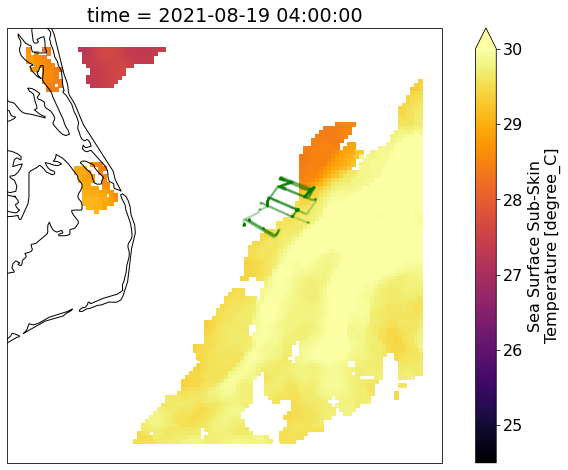

In [72]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
goes_ds.sea_surface_temperature[100,75:175, 100:200].plot(ax=ax, vmin=24.5, vmax=30, cmap='inferno')
gdf.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].plot(ax=ax, markersize=2, color='green', alpha=.05)
# fig.savefig('sst_sept0523_studypoints.png',dpi=400)

In [21]:
plt.rcParams.update({'font.size': 16})

In [32]:
goes_6h = goes_ds.sea_surface_temperature[400:,:, :].resample(time="6H", skipna=True).median()

In [22]:
# goes_6h = goes_ds.sea_surface_temperature[400:,:, :].resample(time="6H", skipna=True).median()
# for i in range(38, goes_6h.shape[0]):
#     fig,ax = plt.subplots(figsize=(11,9),subplot_kw=dict(projection=crs.PlateCarree()))
#     goes_6h[i,:, :].plot(ax=ax, vmin=25,vmax=30,cmap='inferno' )
#     ax.coastlines(resolution='10m')
#     #ax.plot([281.5, 285.5], [31, 35], color='grey',linestyle='--')
#     #for i, row in gdf[gdf.date==current_date].iterrows():
#         #for each one that exists now, find all that match its eddy_id, then run through each pair and plot it
#         #ax.scatter(row.lon, row.lat, color='black')
#     gdf.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].plot(ax=ax, cmap='viridis', alpha=0.02, markersize=20)
#     plt.savefig(f"tmp_imgs/sst_goes_longer_{i:04}.png")
#     plt.close()

### Visualizing the CDOM/Ship Data

In [23]:
# gdf.reset_index().drop(columns=['datetime', 'utc_dt']).to_file('compass_cruise.shp')

In [24]:
df.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

<ipython-input-25-df14b368788f>:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  cdom_df.loc['2021-09-5 11:00:00':'2021-09-9 18:30:00'].rolling(window=60).mean().plot(y=' V', ax=ax)


(0.05, 0.5)

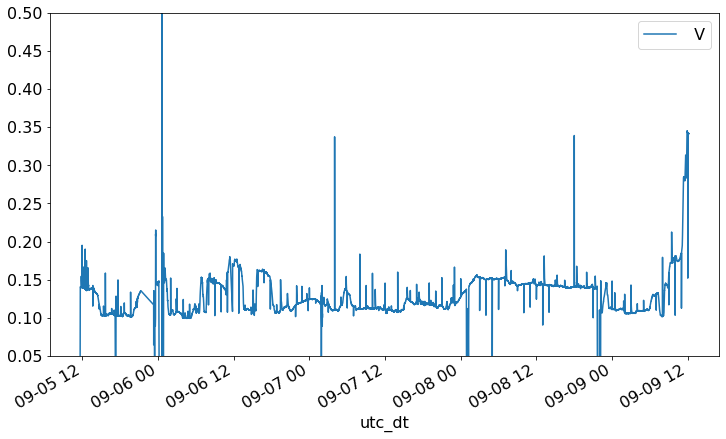

In [25]:
fig,ax = plt.subplots(figsize=(12,7))
cdom_df.loc['2021-09-5 11:00:00':'2021-09-9 18:30:00'].rolling(window=60).mean().plot(y=' V', ax=ax)
ax.set_ylim(0.05,.5)

In [26]:
df.loc['2021-09-5 13:00:00':'2021-09-5 17:30:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

## Working through each transect with data and SST

In [40]:
datetimeindex = goes_6h.indexes['time'].to_datetimeindex()   
goes_6h['time'] = datetimeindex

In [ ]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
goes_ds.sea_surface_temperature[100,:, :].plot(ax=ax, vmin=24.5, vmax=30, cmap='inferno')
gdf.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].plot(ax=ax, markersize=2, color='green', alpha=.05)
# fig.savefig('sst_sept0523_studypoints.png',dpi=400)

In [85]:
goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=0), pd.to_datetime(end_times[i])+timedelta(hours=0)))

<xarray.Dataset>
Dimensions:                  (latitude: 301, longitude: 301, time: 5)
Coordinates:
  * time                     (time) object 2021-09-05 13:00:00 ... 2021-09-05...
  * latitude                 (latitude) float32 38.01 37.99 ... 32.03 32.01
  * longitude                (longitude) float32 -77.99 -77.97 ... -72.01 -71.99
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 ...
Attributes:
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              Grid
    col_count:                  5920
    col_start:                  2290
    comment:                    SSTs are a weighted average of the SSTs of co...
    Conventions:                CF-1.7, COARDS, ACDD-1.3
    creator_email:              Alex.Ignatov@noaa.gov
    creator_name:               Alex Ignatov
    creator_type:               person
    creator_url:                http://www.star.nesdis.noaa.gov
    date_created:               2019-05-02T23:19:39Z
    Easternmost_Easting:        -71.99
    gds_version_id:             02.0
    geospatial_lat_max:         38.01
    geospatial_lat_min:         32.01
    geospatial_lat_resolution:  0.02
    geospatial_lat_units:       degrees_north
    geospatial_lon_max:         -71.99
    geospatial_lon_min:         -77.99
    geospatial_lon_resolution:  0.02
    geospatial_lon_units:       degrees_east
    history:                    Created by the L2P-to-L3U conversion tool,  w...
    id:                         ABI_G16-STAR-L3C-v2.7
    infoUrl:                    https://podaac.jpl.nasa.gov/dataset/ABI_G16-S...
    institution:                NOAA/NESDIS/STAR
    keywords:                   abi, angle, atmosphere, atmospheric, bias, co...
    keywords_vocabulary:        GCMD Science Keywords
    license:                    GHRSST protocol describes data use as free an...
    metadata_link:              <TBD>
    naming_authority:           org.ghrsst
    Northernmost_Northing:      38.01
    platform:                   GOES-16
    processing_level:           L3U
    product_version:            L2P algorithm V2.70; L3U algorithm V4.1.5
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_email:            ghrsst-po@nceo.ac.uk
    publisher_name:             The GHRSST Project Office
    publisher_type:             group
    publisher_url:              https://www.ghrsst.org
    references:                 Data convention: GHRSST Data Specification (G...
    row_count:                  5920
    row_start:                  1540
    sensor:                     ABI
    source:                     l2p_source : 20181202090000-STAR-L2P_GHRSST-S...
    sourceUrl:                  https://thredds.jpl.nasa.gov/thredds/dodsC/Oc...
    Southernmost_Northing:      32.01
    spatial_resolution:         0.02 deg
    sst_luts:                   LUT_ABI_G16_L2C_DEPTH_DAYNIGHT_V01.06_2019042...
    standard_name_vocabulary:   CF Standard Name Table v70
    Sub_Lon:                    -75.0
    summary:                    Sea surface temperature retrievals produced b...
    testOutOfDate:              now-1day
    time_coverage_end:          2021-09-14T13:00:00Z
    time_coverage_start:        2021-08-15T00:00:00Z
    title:                      GOES-16 ABI L3C SST (ABI G16-STAR-L3C-v2.70),...
    Westernmost_Easting:        -77.99

In [150]:
plt.rcParams.update({'font.size': 16})

In [163]:
i=7

In [164]:
titles[i], start_times[i], end_times[i]

('Transect 8 (Sept 6 nighttime)', '2021-09-7 6:45:00', '2021-09-7 9:00:00')

In [165]:
i=8

In [166]:
titles[i], start_times[i], end_times[i]

('Transect 9 (Sept 7 daytime AM)', '2021-09-7 12:10:00', '2021-09-7 15:30:00')

In [168]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']
hours = [0,0,0,0,0,0,0,0,0]

titles = ['Transect 1 (Sept 5 daytime AM)', 'Transect 2 (Sept 5 daytime PM)', 'Transect 3 (Sept 5 nighttime)', 'Transect 4 (Sept 5 nighttime)', 
        'Transect 5 (Sept 6 daytime AM)', 'Transect 6 (Sept 6 daytime PM)', 'Transect 7 (Sept 6 nighttime)', 'Transect 8 (Sept 6 nighttime)',
        'Transect 9 (Sept 7 daytime AM)']

for i in range(9):
    # time series plot
    fig, ax = plt.subplots(figsize=(10,7))
    
    ax1 = ax.twinx()
    ax2 = ax.twinx()

    ax.set_ylim(25.5, 30.5)
    ax1.set_ylim(33, 37)
    ax2.set_ylim(.08, .2)

    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("Temperature (C)")
    ax1.set_ylabel("Salinity (PSU)")
    ax2.set_ylabel("CDOM (volts)")

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)
    
    p1, = ax.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], color='red', label='Temp')
    p2, = ax1.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--sal'], label='Salinity')
    p3 = ax2.scatter(cdom_df.loc[start_times[i]:end_times[i]].rolling(window=30).mean().index, cdom_df.loc[start_times[i]:end_times[i]].rolling(window=30).mean()[' V'], color='brown', label='CDOM', s=2)
    
    ax.set_title(titles[i])


#     p1, = ax.plot([0, 1, 2], [0, 1, 2],    color=color1, label="Density")
#     p2, = ax1.plot([0, 1, 2], [0, 3, 2],    color=color2, label="Temperature")
#     p3, = ax2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

    lns = [p1, p2, p3]
    ax.legend(handles=lns, loc='best')

    # right, left, top, bottom
    ax2.spines['right'].set_position(('outward', 80))

    # no x-ticks                 
#     ax2.xaxis.set_ticks([])
    fig.autofmt_xdate(rotation=45)

    # Sometimes handy, same for xaxis
    #par2.yaxis.set_ticks_position('right')

    # Move "Velocity"-axis to the left
    # par2.spines['left'].set_position(('outward', 60))
    # par2.spines['left'].set_visible(True)
    # par2.yaxis.set_label_position('left')
    # par2.yaxis.set_ticks_position('left')

    ax.yaxis.label.set_color(p1.get_color())
    ax1.yaxis.label.set_color(p2.get_color())
    ax2.yaxis.label.set_color('brown')

    # Adjust spacings w.r.t. figsize
    fig.tight_layout()
    fig.savefig('figs/'+titles[i] +'.png')
    plt.close()
    
    
    
    # SST image
    
    fig, ax = plt.subplots(1,2, figsize=(20,8), subplot_kw=dict(projection=crs.PlateCarree()))
    ax[0].coastlines(resolution='10m')
    goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,:,:].mean(dim='time').plot(ax=ax[0], vmin=24.5, vmax=30, cmap='inferno')
    gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[0], markersize=2, color='green', alpha=.05)
    
    ax[1].coastlines(resolution='10m')
    goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,75:175, 100:200].mean(dim='time').plot(ax=ax[1], vmin=24.5, vmax=30, cmap='inferno')
    gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[1], markersize=2, color='green', alpha=.05)
    # fig.savefig('sst_sept0523_studypoints.png',dpi=400)
    ax[0].set_title(titles[i] + ' overview')
    ax[1].set_title(titles[i] + ' zoom')
    fig.tight_layout()
    fig.savefig('figs/'+titles[i] +'sat_overview.png')
    plt.close()

    # fig.savefig('transect' + str(i) '_s_t.png')

<ipython-input-168-2d1edebca396>:31: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  p3 = ax2.scatter(cdom_df.loc[start_times[i]:end_times[i]].rolling(window=30).mean().index, cdom_df.loc[start_times[i]:end_times[i]].rolling(window=30).mean()[' V'], color='brown', label='CDOM', s=2)
<ipython-input-168-2d1edebca396>:31: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  p3 = ax2.scatter(cdom_df.loc[start_times[i]:end_times[i]].rolling(window=30).mean().index, cdom_df.loc[start_times[i]:end_times[i]].rolling(window=30).mean()[' V'], color='brown', label='CDOM', s=2)
<ipython-input-168-2d1edebca396>:31: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  p3 = 